In [24]:
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

# read data

In [2]:
words = open('../data/names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [5]:
chars = sorted(list(set(''.join(words))))

# util

In [6]:
itos = {}
itos[0] = '.'
itos |= {i+1: s for i, s in enumerate(chars)}

In [7]:
stoi = {s: i for i, s in itos.items()}

In [8]:
def cmp(s, dt, t):
    """
    s is the message, dt is our grad, t is from pytorch
    """
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

# Build a neural language model

## prepare data

In [9]:
def build_dataset(data):
    block_size = 3
    X, Y = [], []
    for w in data[:]:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            # print(''.join([itos[i] for i in context]), '--->', itos[ix])
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]        

    X = torch.tensor(X)
    Y = torch.tensor(Y)        
    print(X.shape, Y.shape)
    return X, Y

In [10]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
         
Xtr, Ytr = build_dataset(words[:n1])
Xdv, Ydv = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])                               

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


# Train a neural language model

In [11]:
n_emb = 10
n_hidden = 200
block_size = 3

C = torch.randn(len(itos), n_emb)
w1 = torch.randn(n_emb*block_size, n_hidden)
b1 = torch.randn(n_hidden)
w2 = torch.randn(n_hidden, len(itos)) * 0.02
b2 = torch.randn(len(itos)) * 0.01
parameters = [C, w1, b1, w2, b2]

In [12]:
sum(p.nelement() for p in parameters)

11897

In [13]:
for p in parameters:
    p.requires_grad = True

In [14]:
# mini-batch
batch_size = 32
n = batch_size
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix]

In [15]:
# forward
emb = C[Xb] # (32, 3, 2)
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ w1 + b1
h = hpreact.tanh() # (32, 100)
logits = h @ w2 + b2 # (32, 27)
# loss = F.cross_entropy(logits, Yb)
logit_maxes = logits.max(1, keepdim=True).values
norm_logits = logits - logit_maxes
counts = norm_logits.exp()
counts_sum = counts.sum(1, keepdim=True)
counts_sum_inv = counts_sum**-1
probs = counts * counts_sum_inv
logprobs = probs.log()
loss = -logprobs[range(n), Yb].mean()

# backward
for p in parameters:
    p.grad = None
for t in [
    logprobs, 
    probs, 
    counts_sum_inv,
    counts,
    counts_sum,
    norm_logits,
    logits,
    logit_maxes,
    h,
    hpreact,
    embcat,
    emb
]:
    t.retain_grad()
    
loss.backward()
loss

tensor(3.3818, grad_fn=<NegBackward0>)

# maunally compute grads

In [16]:
dlogprobs = torch.zeros_like(logprobs)
dlogprobs[range(n), Yb] = -1.0/n
dprobs = 1.0/probs * dlogprobs
dcounts_sum_inv = (counts * dprobs).sum(1,keepdim=True)
dcounts = (counts_sum_inv * dprobs) # part 1
dcounts_sum = -1*counts_sum**-2 * dcounts_sum_inv
dcounts += torch.ones_like(counts) * dcounts_sum
dnorm_logits = counts * dcounts
dlogits = 1 * dnorm_logits
dlogit_maxes = (-1 * dnorm_logits).sum(1, keepdim=True)
for i in range(n):
    tmp = logits.max(1, keepdim=True).indices.squeeze()[i]
    dlogits[i, tmp] += dlogit_maxes[i][0]
dh = dlogits @ w2.T
dw2 = h.T @ dlogits
db2 = dlogits.sum(0)
dhpreact = (1 - h**2) * dh
dembcat = dhpreact @ w1.T
dw1 = embcat.T @ dhpreact
db1 = dhpreact.sum(0)
demb = dembcat.view(emb.shape)
dC = torch.zeros_like(C)
for k in range(Xb.shape[0]):
    for j in range(Xb.shape[1]):
        ix = Xb[k, j]
        dC[ix] += demb[k, j]
# --------------------------------
cmp('dC', dC, C)
cmp('demb', demb, emb)
cmp('db1', db1, b1)
cmp('dw1', dw1, w1)
cmp('dembcat', dembcat, embcat)
cmp('hpreact', dhpreact, hpreact)
cmp('db2', db2, b2)
cmp('dw2', dw2, w2)
cmp('dh', dh, h)
cmp('dlogit_maxes', dlogit_maxes, logit_maxes)
cmp('dlogits', dlogits, logits)
cmp('dnorm_logits', dnorm_logits, norm_logits)
cmp('dcounts_sum', dcounts_sum, counts_sum)
cmp('dcounts', dcounts, counts)
cmp('dcounts_sum_inv', dcounts_sum_inv, counts_sum_inv)
cmp('probs', dprobs, probs)
cmp('logprobs', dlogprobs, logprobs)

dC              | exact: True  | approximate: True  | maxdiff: 0.0
demb            | exact: True  | approximate: True  | maxdiff: 0.0
db1             | exact: True  | approximate: True  | maxdiff: 0.0
dw1             | exact: True  | approximate: True  | maxdiff: 0.0
dembcat         | exact: True  | approximate: True  | maxdiff: 0.0
hpreact         | exact: True  | approximate: True  | maxdiff: 0.0
db2             | exact: True  | approximate: True  | maxdiff: 0.0
dw2             | exact: True  | approximate: True  | maxdiff: 0.0
dh              | exact: True  | approximate: True  | maxdiff: 0.0
dlogit_maxes    | exact: True  | approximate: True  | maxdiff: 0.0
dlogits         | exact: True  | approximate: True  | maxdiff: 0.0
dnorm_logits    | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum     | exact: True  | approximate: True  | maxdiff: 0.0
dcounts         | exact: True  | approximate: True  | maxdiff: 0.0
dcounts_sum_inv | exact: True  | approximate: True  | maxdiff:

# combine functions

In [17]:
dlogits = F.softmax(logits, 1)
dlogits[range(n), Yb] -= 1
dlogits /= n
# --------------------------------
cmp('dlogits', dlogits, logits)

dlogits         | exact: False | approximate: True  | maxdiff: 6.6356733441352844e-09


In [18]:
dlogits.shape, logits.shape, Yb.shape

(torch.Size([32, 27]), torch.Size([32, 27]), torch.Size([32]))

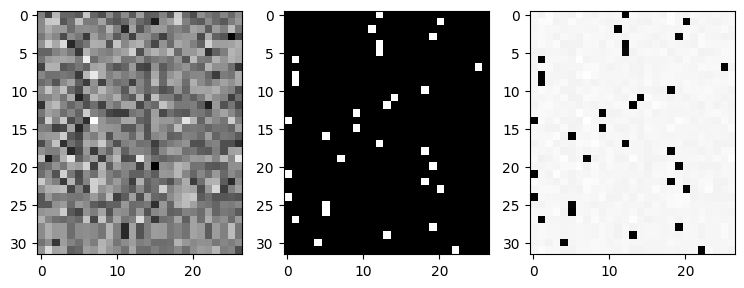

In [19]:
plt.figure(figsize=(9,9))
ax1 = plt.subplot(131)
plt.imshow(logits.detach(), cmap='gray')
plt.subplot(132, sharex = ax1)
plt.imshow(F.one_hot(Yb, num_classes=logits.shape[1]), cmap='gray')
plt.subplot(133, sharex = ax1)
plt.imshow(dlogits.detach(), cmap='gray')
plt.show()

In [20]:
dlogits.sum(1).abs().max()

tensor(5.5879e-09, grad_fn=<MaxBackward1>)

## Why does dlogits sum up to 1???

In [21]:
# ?

## compute loss on train/dev/test

In [22]:
def eval_dataset(X, Y):
    with torch.no_grad():
        emb = C[X] # (32, 3, 2)
        h = (emb.view(emb.shape[0], -1) @ w1 + b1).tanh() # (32, 100)
        logits = h @ w2 + b2 # (32, 27)
        loss = F.cross_entropy(logits, Y)
        print(loss.item())

In [23]:
eval_dataset(Xtr, Ytr)
eval_dataset(Xdv, Ydv)
# eval_dataset(Xte, Yte)

3.328719139099121
3.329540967941284
